对FreeVC的推理阶段进行测试：不含说话人信息的导入

测试结果显示：针对未知说话人的情况下，FreeVC能够保持源语音的内容信息，目标说话人的信息转换情况存在不足。

In [ ]:
import os
import argparse
import torch
import librosa
import time
from scipy.io.wavfile import write
from IPython.display import Audio
from tqdm import tqdm
import Model.Pretrained.FreeVC.utils as utils
from Model.Pretrained.FreeVC.models import SynthesizerTrn
from Script.load_mel_and_spec import mel_spectrogram_torch
import numpy as np
import matplotlib.pyplot as plt

ptfile = '/data/xuyx/Code/Ensemble_20240627/Model/Pretrained/FreeVC/freevc-s.pth'
hpfile = '/data/xuyx/Code/Ensemble_20240627/Model/Pretrained/FreeVC/configs/freevc-s.json'

hps = utils.get_hparams_from_file(hpfile)
print("Loading model...")
net_g = SynthesizerTrn(hps.data.filter_length // 2 + 1,
                        hps.train.segment_size // hps.data.hop_length,
                        **hps.model).cuda()
print("Loading checkpoint...")
# net_g_, _, _, _ = utils.load_checkpoint(ptfile, net_g, None, True)
_ = utils.load_checkpoint(ptfile, net_g, None, True)

print("Loading WavLM for content...")
cmodel = utils.get_cmodel(0)

tgt = '/data/xuyx/Code/Ensemble_20240627/Sample/909_131041_000019_000002.wav'
src = '/data/xuyx/Code/Ensemble_20240627/Sample/E_0006552470.flac'
print("Synthesizing...")
with torch.no_grad():
    # tgt
    wav_tgt, _ = librosa.load(tgt, sr=hps.data.sampling_rate)
    wav_tgt, _ = librosa.effects.trim(wav_tgt, top_db=20)

    wav_tgt = torch.from_numpy(wav_tgt).unsqueeze(0).cuda()
    mel_tgt = mel_spectrogram_torch(
        wav_tgt, 
        hps.data.filter_length,
        hps.data.n_mel_channels,
        hps.data.sampling_rate,
        hps.data.hop_length,
        hps.data.win_length,
        hps.data.mel_fmin,
        hps.data.mel_fmax
    )
    # src
    wav_src, _ = librosa.load(src, sr=hps.data.sampling_rate)
    wav_src = torch.from_numpy(wav_src).unsqueeze(0).cuda()
    c = utils.get_content(cmodel, wav_src)
    print(c.size())
    
    audio = net_g.infer(c, mel=mel_tgt)
    audio = audio[0][0].data.cpu().float().numpy()
    # audio_play = Audio(audio)
    # display(audio_play)
    outdir = '/data/xuyx/Code/Ensemble_20240627/Sample/909_131041_000019_000002_recon.wav'
    write(outdir, hps.data.sampling_rate, audio)

    wav_tgt_y, sr = librosa.load(src, sr=None)  # 加载音频文件，sr=None 使其保持原始采样率
    mel_spec_tgt = librosa.feature.melspectrogram(y=wav_tgt_y, sr=hps.data.sampling_rate, n_fft=2048, hop_length=512, n_mels=128)
    mel_spec_tgt_db = librosa.power_to_db(mel_spec_tgt, ref=np.max)  # 将功率谱转换为对数刻度（分贝）
    # 可视化梅尔谱图
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(mel_spec_tgt_db, sr=hps.data.sampling_rate, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Mel Frequency')
    plt.show()

    # audio = np.array(audio)
    # 计算Mel谱图
    mel_spec_recon = librosa.feature.melspectrogram(y=audio, sr=hps.data.sampling_rate, n_fft=2048, hop_length=512, n_mels=128)
    mel_spec_recon_db = librosa.power_to_db(mel_spec_recon, ref=np.max)  # 将功率谱转换为对数刻度（分贝）
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(mel_spec_recon_db, sr=hps.data.sampling_rate, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Mel Frequency')
    plt.show()

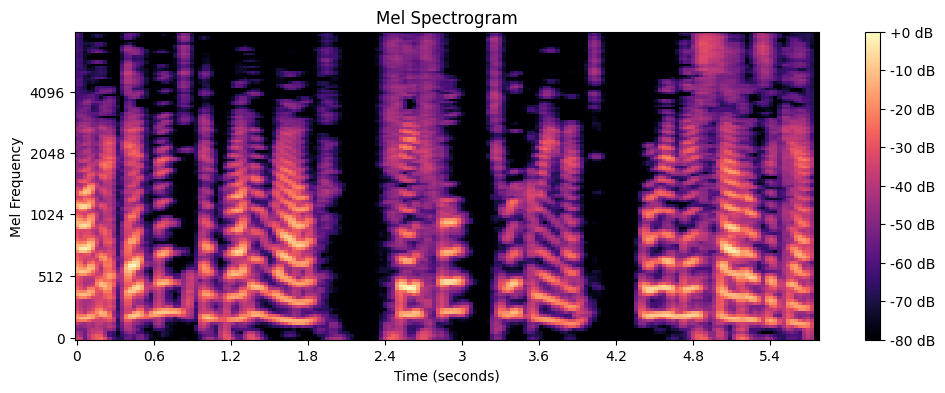

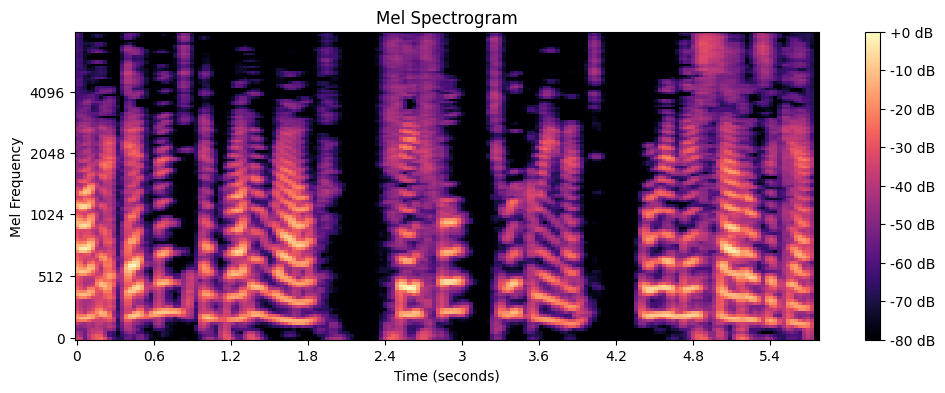

In [9]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

tgt = '/data/xuyx/Code/Ensemble_20240627/Sample/E_0000002079.flac'
wav_tgt, sampling_rate = librosa.load(tgt, sr=None)

wav_tgt_trim, _ = librosa.effects.trim(wav_tgt, top_db=20)
mel_wav_tgt_trim = librosa.feature.melspectrogram(y=wav_tgt_trim, sr=sampling_rate, n_fft=2048, hop_length=512, n_mels=128)
mel_wav_tgt_trim_db = librosa.power_to_db(mel_wav_tgt_trim, ref=np.max)  # 将功率谱转换为对数刻度（分贝）
# 可视化梅尔谱图
plt.figure(figsize=(12, 4))
librosa.display.specshow(mel_wav_tgt_trim_db, sr=sampling_rate, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.xlabel('Time (seconds)')
plt.ylabel('Mel Frequency')
plt.show()

mel_spec_tgt = librosa.feature.melspectrogram(y=wav_tgt, sr=sampling_rate, n_fft=2048, hop_length=512, n_mels=128)
mel_spec_tgt_db = librosa.power_to_db(mel_spec_tgt, ref=np.max)  # 将功率谱转换为对数刻度（分贝）
# 可视化梅尔谱图
plt.figure(figsize=(12, 4))
librosa.display.specshow(mel_spec_tgt_db, sr=sampling_rate, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.xlabel('Time (seconds)')
plt.ylabel('Mel Frequency')
plt.show()